# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName("ddam_group2_2425") \
    .getOrCreate()

path = '/content/drive/MyDrive/DDAM Group 2/credit_card_transaction_train.csv'
df = spark.read.csv(path, header=True, inferSchema=True)

df.printSchema()

# General description of data
df.describe().show()

from pyspark.sql.functions import col, when, count

# Define aliases for missing values
missing_value_aliases = ['None', 'NULL', 'na', 'n/a', 'NaN', '']

# Check for missing values in all columns
missing = df.select([count(
    when(
        col(c).isin(missing_value_aliases) | col(c).isNull() | (col(c) == ''),
        c
    )
).alias(c) for c in df.columns])

# Execute and show the results
missing.show()

# Step 2: Cast the necessary columns to the specified data types
df = df.withColumn("cc_num", col("cc_num").cast("string"))
df = df.withColumn("zip", col("zip").cast("string"))


from pyspark.sql import functions as F

# Step 3: Drop unnecessary columns
df = df.drop("Unnamed: 0", "unix_time", "first", "last", "merch_zipcode")

# Step 4: Remove the "fraud_" prefix and handle longer merchant names dynamically with a very large upper bound
df = df.withColumn("merchant",
                   when(col("merchant").startswith("fraud_"),
                        col("merchant").substr(7, 1000))  # Use the maximum integer value
                   .otherwise(col("merchant")))

# Step 5: Split the 'trans_date_trans_time' column into separate hour, day, month, and year columns
df = df.withColumn("hour", F.hour("trans_date_trans_time"))
df = df.withColumn("day", F.dayofmonth("trans_date_trans_time"))
df = df.withColumn("month", F.month("trans_date_trans_time"))
df = df.withColumn("year", F.year("trans_date_trans_time"))

# Step 6: Convert dob column into the age of the user
from pyspark.sql.functions import datediff, current_date
from pyspark.sql.types import IntegerType

df = df.withColumn("age", (datediff(current_date(), col("dob")) / 365).cast(IntegerType()))
df.show()

Mounted at /content/drive
root
 |-- Unnamed: 0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)

+-------+-----------------+

In [ ]:
# Add a new column "off_on" with "online" or "offline" based on category
df = df.withColumn(
    "online",
    when(col("category").like("%_net"), 1)  # Check if category ends with "_net"
    .when(col("category").like("%_pos"), 0)  # Check if category ends with "_pos"
    .otherwise(0)  # Default to "offline" for other cases
)
df.show()

+---------------------+-------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+------------------+------------------+--------+----+---+-----+----+---+------+
|trans_date_trans_time|             cc_num|            merchant|     category|   amt|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num|         merch_lat|        merch_long|is_fraud|hour|day|month|year|age|online|
+---------------------+-------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+------------------+------------------+--------+----+---+-----+----+---+------+
|  2019-01-01 00:00:18|   2703186189652095|Rippin, Kub and

In [ ]:
offline_df = df.filter(col("online") == 0) # select where online False (0)

In [ ]:
# Extract the header from the first part file
offline_df.write.csv("geo_offline_pre.csv", header=True)

!head -n 1 geo_offline_pre.csv/part-00000-*.csv > geo_offline_pre_combined.csv

# Append all data rows from all part files, skipping the header rows
!tail -n +2 -q geo_offline_pre.csv/part-*.csv >> geo_offline_pre_combined.csv

test = spark.read.csv("/content/geo_offline_pre_combined.csv", header=True, inferSchema=True)
test.cache()
print(test.count())
test.printSchema()

1090393
root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- online: integer (nullable = true)



# GEOSPATIAL ANALYSIS

In [1]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.sql.functions import col


from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
colors = {
    "Blue": "#1f77b4",
    "Green": "#2ca02c",
    "Red": "#d62728",
    "Grey": "#7f7f7f",
}

from datetime import datetime
import holidays

from pyspark.sql import SparkSession
import os

# Create the directory if it doesn't exist
event_log_dir = "/tmp/spark-events"
os.makedirs(event_log_dir, exist_ok=True)

# Get total available system memory
total_memory_gb = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024. ** 3)

# Set Spark to use a high percentage of system memory
spark = SparkSession.builder \
    .appName("GeoAnalysisDDAM") \
    .config("spark.executor.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.driver.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/tmp/spark-events") \
    .getOrCreate()

# Access SparkContext if needed
sc = spark.sparkContext

file_path = '/content/drive/MyDrive/DDAM Group 2/geo_offline_pre_combined.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

Mounted at /content/drive


In [2]:
# drop columns
df = df.drop("gender", "street", "city", "state", "zip", "city_pop", "job", "dob", "year", "online") # we are using only offline data

In [3]:
df.count()

1090393

In [ ]:
%%time
from pyspark.sql import functions as F
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(F.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = F.sin(dlat / 2) ** 2 + F.cos(lat1) * F.cos(lat2) * F.sin(dlon / 2) ** 2
    c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))
    return R * c  # Returns distance in kilometers

df = df.withColumn(
    'distance_from_home',
    haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
)

CPU times: user 15.7 ms, sys: 303 µs, total: 16 ms
Wall time: 291 ms


In [ ]:
# Extract the header from the first part file
df.write.csv("geo_offline_pre.csv", header=True)

!head -n 1 geo_offline_pre.csv/part-00000-*.csv > geo_offline_pre_combined.csv

# Append all data rows from all part files, skipping the header rows
!tail -n +2 -q geo_offline_pre.csv/part-*.csv >> geo_offline_pre_combined.csv

test = spark.read.csv("/content/geo_offline_pre_combined.csv", header=True, inferSchema=True)
test.cache()
print(test.count())
test.printSchema()

1090393
root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- prev_lat: double (nullable = true)
 |-- prev_long: double (nullable = true)
 |-- distance_from_home: double (nullable = true)



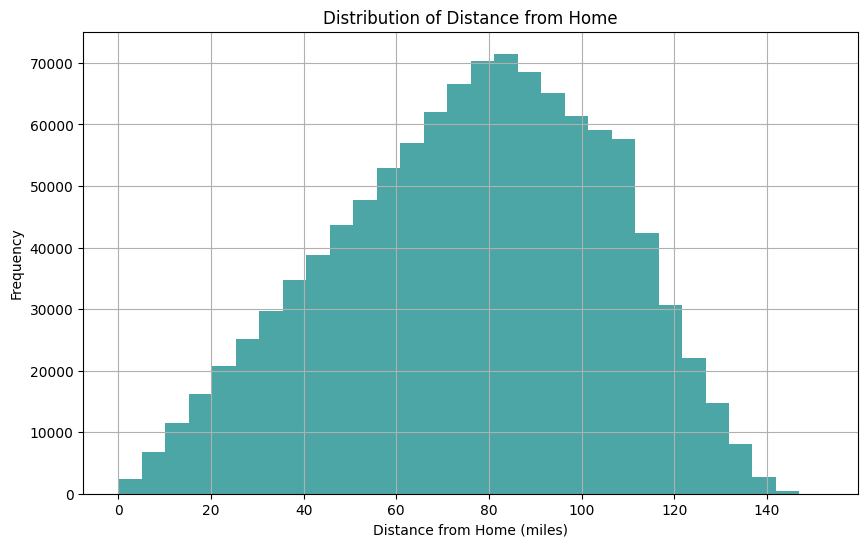

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Filter valid distances (exclude null or unrealistic values)
df_filtered = df.filter((col("distance_from_home").isNotNull()) & (col("distance_from_home") >= 0))

# Convert the filtered DataFrame to Pandas for plotting
df_pandas = df_filtered.select("distance_from_home").toPandas()

# Extract the distance data as a NumPy array
distance_data = df_pandas["distance_from_home"].to_numpy()

# Create the histogram with Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(distance_data, bins=30, color='teal', alpha=0.7)

# Add labels and title
plt.title("Distribution of Distance from Home")
plt.xlabel("Distance from Home (miles)")
plt.ylabel("Frequency")

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [4]:
# highlight fraudulent transactions with large distances from home
filtered_data = df.filter(col("distance_from_home") > 80)
filtered_data.count()

520307

In [5]:
filtered_data.printSchema()

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- prev_lat: double (nullable = true)
 |-- prev_long: double (nullable = true)
 |-- distance_from_home: double (nullable = true)



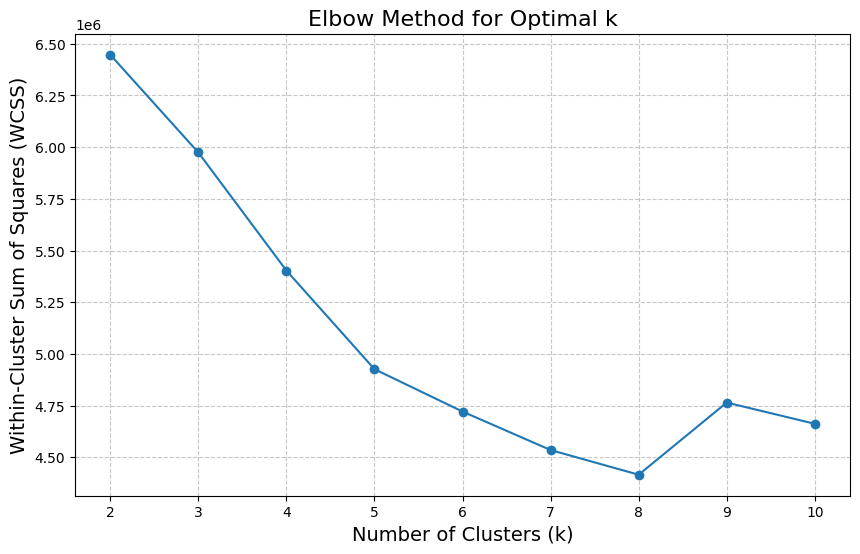

CPU times: user 3.27 s, sys: 458 ms, total: 3.73 s
Wall time: 6min 53s


In [6]:
%%time
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Select relevant columns for clustering
# For categorical features, we will apply StringIndexer to convert them to numerical values
categorical_columns = ["merchant", "category", "cc_num"]
numeric_columns = ["amt", "lat", "long", "merch_lat", "merch_long", "is_fraud", "hour",
                   "day", "month", "age", "distance_from_home"]

# Apply StringIndexer to convert categorical columns to numerical
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed") for col in categorical_columns]

# Assemble all features into a single vector
vector_assembler = VectorAssembler(inputCols=numeric_columns + [col+"_indexed" for col in categorical_columns],
                                   outputCol="features")

# Combine indexers and assembler into a pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [vector_assembler])
clustering_data = pipeline.fit(filtered_data).transform(filtered_data)

# Optionally, scale the features (important if there are large differences in scale)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
clustering_data = scaler.fit(clustering_data).transform(clustering_data)

# Range of k values to test
k_values = range(2, 11)
inertia = []  # To store WCSS for each k

# Elbow method to determine optimal k
for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="scaled_features", predictionCol="cluster")
    model = kmeans.fit(clustering_data)
    inertia.append(model.summary.trainingCost)  # WCSS/Inertia

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k", fontsize=16)
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Within-Cluster Sum of Squares (WCSS)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [7]:
%%time
# kmeans with chosen k
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(clustering_data)

# Make predictions (i.e., assign clusters)
clustered_data = model.transform(clustering_data)

# Show the resulting clusters
clustered_data.select("distance_from_home", "amt", "age","cluster").show(5)

+------------------+-----+---+-------+
|distance_from_home|  amt|age|cluster|
+------------------+-----+---+-------+
|  90.0455787484806| 94.2| 82|      1|
| 129.6889545439483| 83.8| 82|      1|
|113.55100469758354|90.72| 82|      1|
|118.96364264842292|38.25| 82|      2|
|119.89453733256082|63.53| 82|      1|
+------------------+-----+---+-------+
only showing top 5 rows

CPU times: user 233 ms, sys: 25.4 ms, total: 258 ms
Wall time: 36.8 s


In [8]:
%%time
from pyspark.ml.evaluation import ClusteringEvaluator
# Compute SSE (Within-Cluster Sum of Squares)
sse = model.summary.trainingCost
print(f"Sum of Squared Errors (SSE): {sse}")

# Compute Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")

Sum of Squared Errors (SSE): 21972143719.08171
Silhouette Score: 0.5036160298503507
CPU times: user 131 ms, sys: 14 ms, total: 145 ms
Wall time: 21.7 s


In [ ]:
import plotly.graph_objects as go
import pandas as pd


clustered_pandas = clustered_data.select("distance_from_home", "amt", "age", "cluster", "is_fraud").toPandas()
clustered_pandas['cluster'] = clustered_pandas['cluster'].astype('category')

cluster_colors = clustered_pandas['cluster'].map({0: 'blue',
                                                  1: 'green',
                                                  2: 'teal',
                                                  3: 'black'})  # Change as per your cluster count

# Set fraud points to red
clustered_pandas['color'] = cluster_colors
# Add 'red' as a category to 'color' to allow assignment
clustered_pandas['color'] = clustered_pandas['color'].astype(pd.CategoricalDtype(categories=list(clustered_pandas['color'].cat.categories) + ['red']))
# Set 'color' to red for fraudulent transactions
clustered_pandas.loc[clustered_pandas['is_fraud'] == 1, 'color'] = 'red'

fig = go.Figure(data=[go.Scatter3d(
    x=clustered_pandas["distance_from_home"],
    y=clustered_pandas["amt"],
    z=clustered_pandas["age"],
    mode="markers",
    marker=dict(
        size=5,
        color=clustered_pandas["color"],
        opacity=0.8
    ),
    text=clustered_pandas["cluster"],
)])

# Update layout for better visualization
fig.update_layout(
    title="3D KMeans Clustering: Distance from Home, Transaction Amount, and Age",
    scene=dict(
        xaxis=dict(title="Distance from Home (miles)"),
        yaxis=dict(title="Transaction Amount ($)"),
        zaxis=dict(title="Age")
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Cluster")
)

# Show the plot
fig.show()